# Lecture 7

The **objective** of this lecture is to introduce omitted variable bias through simulation. This lecture will serve as background exploration in advance of the labs around the marginal abatement curves. There are good reasons to create the marginal abatement curves, mainly to synthesize and compare social research.  However, there are limitations to these simple numbers - and the objective of this lab is to show what happens when certain considerations are left out. We will draw incorrect conclusions from simple regressions, when important variables are omitted.

In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt

Let's create some data.  Define the *true* data generating process as:

$$
health_i = 4 + 3 \cdot income_i - 1.5 \cdot wq_i + \epsilon_i
$$

For each individual $i$, their health indicator is determined by a constant, their income, the density of pathogens in the water, and *everything else* packaged up into a random component $\epsilon_i$.  The impact of each is reflected in the coefficients, which I made up.  Notably, there is a positive impact of income on health and a negative impact of pathogen density -- e.g., bacteria in the water -- on health. 

In this process, the pathogen density and income are positively correlated through population density, or urbanization.  In India, for example, urban areas have higher levels of income and also a higher density of open defecation - there are more people in less area.

Create an array of the given shape and populate it with random samples from a uniform distribution over \[0,1).


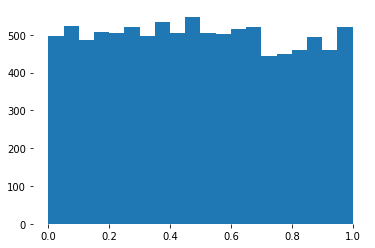

In [101]:
# Make up some data around urbanization. This shape does not reflect reality, 
# but it is convenient -- a uniform distribution with 10K draws.
u = numpy.random.rand(10000)
plt.hist(u, bins=20)
plt.box(on=None)

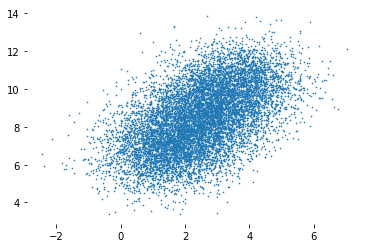

In [103]:
import statsmodels.formula.api as sm

# generate the cofactors and force a positive correlation between the two.
income   = 1 + 3 * u + numpy.random.normal(0, 1, 10000)
pathogen = 6 + 5 * u + numpy.random.normal(0, 1, 10000)

plt.scatter(
    income, 
    pathogen, 
    s=0.4
)

plt.box(on=None)

In [107]:
df = pandas.DataFrame(
    {
        "income": income,
        "pathogen": pathogen,
        "health": 4 + 3 * income - 1.5 * pathogen + numpy.random.normal(0, 1, 10000)
    }
)

df

,income,pathogen,health
0,1.913189,10.212173,-5.159265
1,0.661083,5.534255,-2.420419
2,5.161384,10.356205,3.865930
3,1.813755,7.481432,-2.066238
4,2.881186,10.754717,-2.362216
...,...,...,...
9995,2.772774,7.792201,1.213051
9996,3.892260,9.329622,1.451142
9997,3.490007,9.780260,0.164732
9998,3.048288,11.205912,-3.126594


In [110]:
import statsmodels.formula.api as sm

# run the model with all generating factors
# https://www.statsmodels.org/stable/regression.html
result = sm.ols(formula="health ~ pathogen + income", data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 health   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 5.533e+04
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:43:24   Log-Likelihood:                -14307.
No. Observations:               10000   AIC:                         2.862e+04
Df Residuals:                    9997   BIC:                         2.864e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9913      0.051     78.992      0.000       3.892       4.090
pathogen      -1.4968      0.007   -219.633      0.000      -1.510      -1.483
income         2.9933      0.009    328.396      0.000       2.975       3.011
==============================================================================
Omnibus:                        2.455   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.418
Skew:                          -0.035   Prob(JB):                        0.298
Kurtosis:                       3.029   Cond. No.                         45.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
# Create a function to estimate and return the coefficient on pathogen

def simulation_run(n = 100, f = "health ~ pathogens + income"):
    # Accepts the number of observations for each sample and the 
    # definition of the regression, per statsmodels spec

    u = numpy.random.rand(n)
    income = 1 + 3 * u + numpy.random.normal(0, 1, n)
    wq = 6 + 5 * u + numpy.random.normal(0, 1, n)
    
    df = pandas.DataFrame(
        {
            "income": income,
            "pathogens": wq,
            "health": 4 + 3 * income - 1.5 * wq + numpy.random.normal(0, 1, n)
        }
    )
    
    result = sm.ols(formula=f, data=df).fit()
    
    return result.params["pathogens"]

In [112]:
# B=10K, n=100, 10000
# more precise 
res_low = [simulation_run() for b in range(10000)]
res_high = [simulation_run(n=1000) for b in range(10000)]

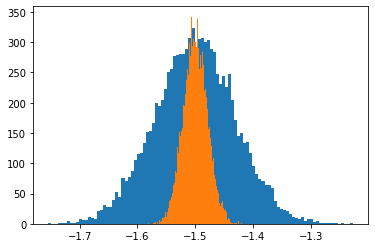

In [113]:
plt.hist(res_low, bins=100)
plt.hist(res_high, bins=100)
plt.show()


Waterborne pathogens can be measured.  Income is more difficult to measure at the individual level.  What happens if we omit `income` from the regression.

The impact of income on health is bundled up into the impact estimate of pathogens.  Income has a positive impact on health, while pathogens have a negative impact.  The omission therefore underestimates the magnitude of the impact.  

In [84]:
res_bias = [simulation_run(f="health ~ pathogens") for b in range(10000)]

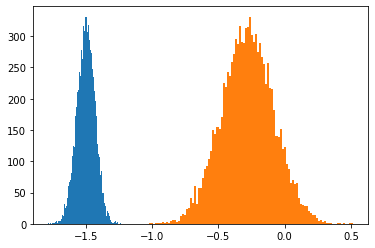

In [85]:
plt.hist(res_low, bins=100)
plt.hist(res_bias, bins=100)
plt.show()

In [ ]:
Two things to note.